<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/ASSGN_q3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip -q install ipympl

In [41]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [42]:
wine_df = pd.read_csv("winequality-white.csv", sep=';')
wine_df["quality"].unique()

array([6, 5, 7, 8, 4, 3, 9])

In [43]:
label = "quality"
features_df = wine_df.drop(columns=['quality'])

In [44]:
def regularized_cov(X, lambda_reg):
    # Note: Ensure the input X is in the form where rows are observations
    sigma = np.cov(X, rowvar=False)  # rowvar=False to treat rows as observations
    n_features = X.shape[1]
    sigma += lambda_reg * np.eye(n_features)
    return sigma

In [45]:
# Access rows/columns by indexing
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to encode labels numerically
le = preprocessing.LabelEncoder()
labels = le.fit_transform(qualities)  # Fit and transform in one step

# Estimate class priors
class_priors = wine_df['quality'].value_counts(normalize=True).sort_index().to_numpy()
num_classes = len(class_priors)

In [46]:
# Calculate mean vectors
grouped = wine_df.groupby('quality')
mean_vectors = grouped.mean().to_numpy()

# Regularization parameter
lambda_reg = 1 / wine_df.shape[1]  # Example regularization, can be tuned

# Compute regularized covariance matrices for each class
regularized_cov_matrices = np.array([
    regularized_cov(X[labels == l], lambda_reg)
    for l in range(num_classes)
])

# Number of samples per class
N_per_l = grouped.size().to_numpy()


In [47]:
gmm = {
    'priors': class_priors,
    'mu': mean_vectors,
    'Sigma': regularized_cov_matrices
}

print(N_per_l)

[  20  163 1457 2198  880  175    5]


In [48]:
from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [49]:
def calculate_class_conditional_likelihoods(X, gmm_params, num_classes):
    """
    Compute the likelihood of data given each class.

    Args:
        X (np.ndarray): The dataset for which likelihoods are calculated.
        gmm_params (dict): Gaussian mixture model parameters with keys 'mu', 'Sigma'.
        num_classes (int): Number of unique classes.

    Returns:
        np.ndarray: Likelihoods of each class given the data.
    """
    return np.array([
        multivariate_normal.pdf(X, mean=gmm_params['mu'][i], cov=gmm_params['Sigma'][i])
        for i in range(num_classes)
    ])
def calculate_posteriors(likelihoods, priors):
    """Calculate posterior probabilities using Bayes' rule."""
    priors_diagonal = np.diag(priors)
    return priors_diagonal.dot(likelihoods)

def calculate_risks(posteriors, loss_matrix):
    """Calculate risks for each class and sample."""
    return loss_matrix.dot(posteriors)

def classify(risks):
    """Classify data points into the class with minimum risk."""
    return np.argmin(risks, axis=0)

def perform_erm_classification(X, Lambda, gmm_params, num_classes):
    """
    Perform Empirical Risk Minimization (ERM) classification based on Gaussian mixture model parameters.

    Args:
        X (np.ndarray): Data points to classify.
        Lambda (np.ndarray): Loss matrix.
        gmm_params (dict): Parameters of the Gaussian Mixture Model including 'mu', 'Sigma', and 'priors'.

    Returns:
        np.ndarray: Predicted class labels for each data point.
    """
    #num_classes = len(gmm_params['priors'])  # Explicitly calculating the number of classes
    likelihoods = calculate_class_conditional_likelihoods(X, gmm_params, num_classes)
    posteriors = calculate_posteriors(likelihoods, gmm_params['priors'])
    risks = calculate_risks(posteriors, Lambda)
    return classify(risks)

In [68]:
%matplotlib widget
from sys import float_info  # Threshold smallest positive floating value
import matplotlib.pyplot as plt # For general plotting

In [69]:
from google.colab import output
output.enable_custom_widget_manager()

Confusion Matrix (rows: Predicted class, columns: True class):


Text(0.5, 0, 'True Labels')

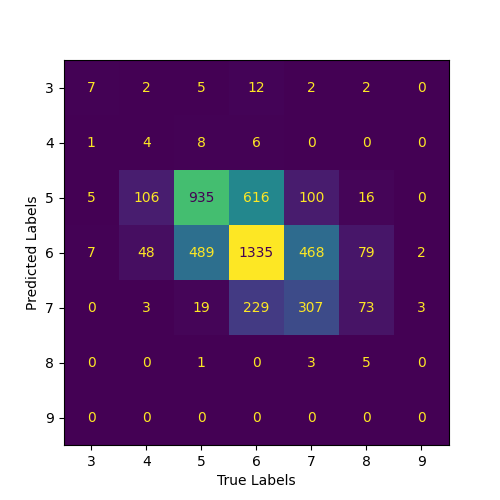

In [70]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
fig, ax = plt.subplots(figsize=(5, 5))
conf_display = ConfusionMatrixDisplay.from_predictions(decisions, labels, ax=ax, display_labels=['3', '4', '5', '6', '7', '8', '9'], colorbar=False)
plt.ylabel('Predicted Labels')
plt.xlabel('True Labels')

In [71]:
# Total number of rows/samples
N = len(wine_df.index)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total number of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Total number of Misclassified Samples: 2305
Empirically Estimated Probability of Error: 0.4706


In [73]:
numeric_wine_df = wine_df.select_dtypes(include=[np.number])
corr_matrix = numeric_wine_df.corr()
corr_matrix["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free sulfur dioxide     0.008158
citric acid            -0.009209
residual sugar         -0.097577
fixed acidity          -0.113663
total sulfur dioxide   -0.174737
volatile acidity       -0.194723
chlorides              -0.209934
density                -0.307123
Name: quality, dtype: float64

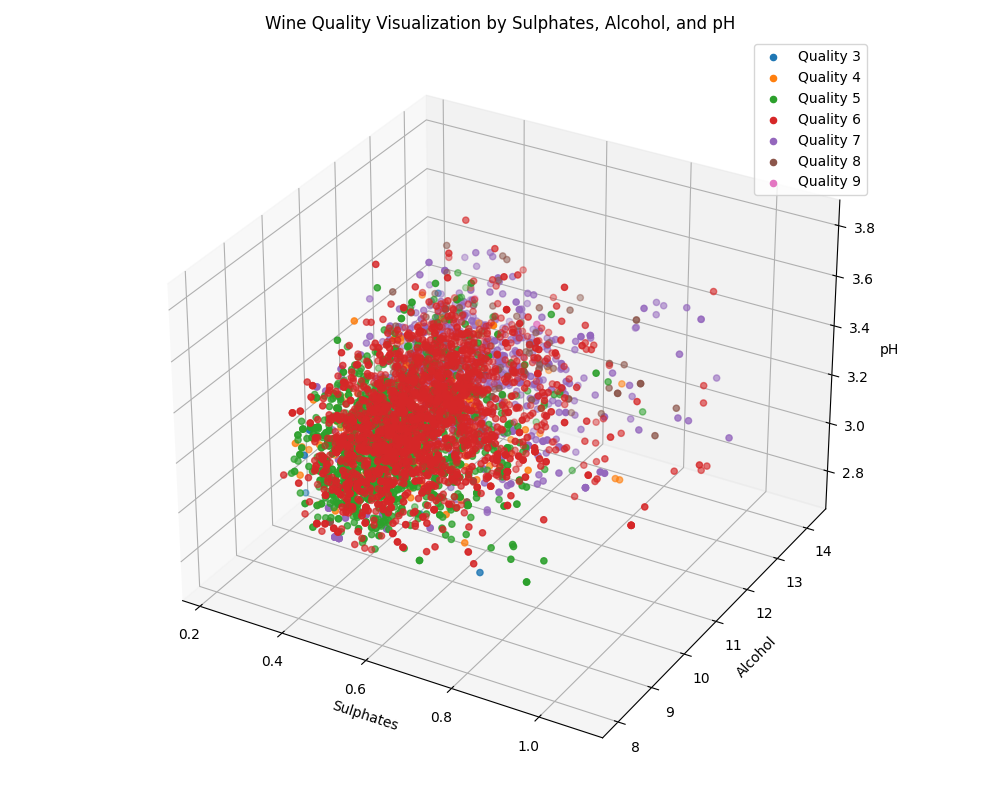

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming wine_df is already defined and loaded
fig = plt.figure(figsize=(10, 8))  # Define the figure size
ax = fig.add_subplot(111, projection='3d')  # Add a 3D subplot

# Get unique qualities and sort them
unique_qualities = np.sort(wine_df['quality'].unique())

# Iterate through the sorted unique qualities
for q in unique_qualities:
    subset = wine_df[wine_df['quality'] == q]
    ax.scatter(subset['sulphates'], subset['alcohol'], subset['pH'], label=f"Quality {q}")

# Set labels for each axis based on the features being plotted
ax.set_xlabel("Sulphates")
ax.set_ylabel("Alcohol")
ax.set_zlabel("pH")

# Add a title and a legend to the plot
plt.title("Wine Quality Visualization by Sulphates, Alcohol, and pH")
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [75]:
from sklearn.decomposition import PCA

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


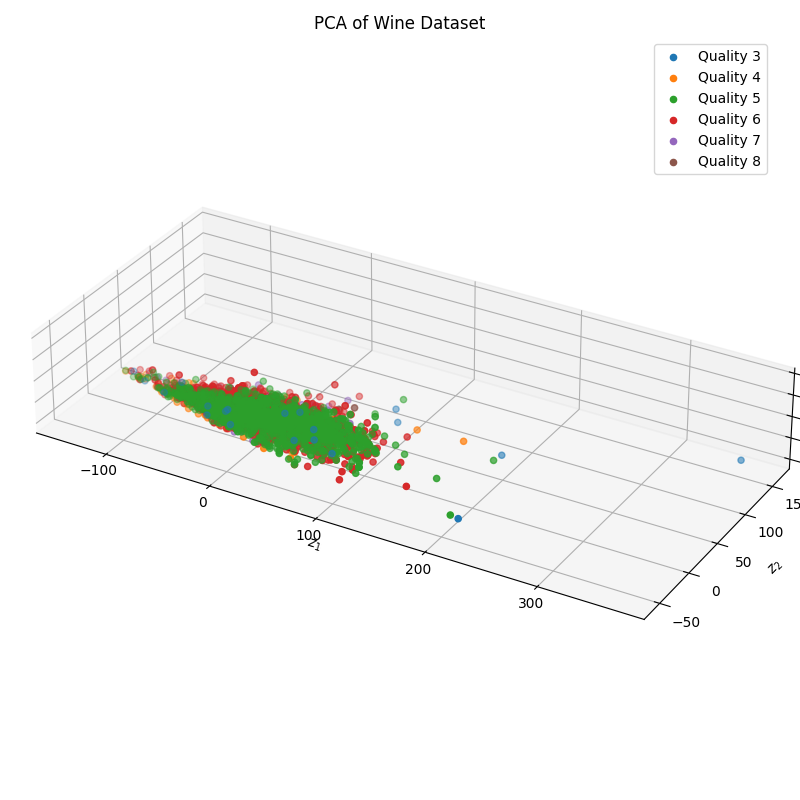

In [76]:
fig = plt.figure(figsize=(8,8))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[wine_df['quality']==q, 0],
                      Z[wine_df['quality']==q, 1],
                      Z[wine_df['quality']==q, 2], label="Quality {}".format(q))

ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()